In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
from DFTStructureGenerator import DFThandle, Tool

In [ ]:
from matplotlib import pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold
import pickle
import numpy as np
import os
np.random.seed(0)

In [4]:
data_dir = "Data"
csv_dir = os.path.join(data_dir, "Iteration_2", "Result")
row_csv = "Data_clear.csv"
target_csv = "Data_clear_with_sites.csv"

In [40]:
binol_3_3 = [ 2,  3,  4,  5,  6, 26, 27, 39, 35, 31, 42, 41, 40, 34, 32, 30, 28, 29, 44, 33, 37, 43, 36, 38]
binol_4_4 = [7, 8, 9]
binol_6_6 = [10, 11, 12, 13, 14, 15, 16, 17]
binol_7_7 = [18, 19, 20, 21, 22]
binol_other = [ 1, 23, 25, 24]
all_binol_split = [binol_3_3, binol_4_4, binol_6_6, binol_7_7, binol_other]
print([len(each) for each in all_binol_split])

[24, 3, 8, 5, 4]


# 1. Data Collection

In [8]:
with open(r"Data/all_fp_map.pkl", 'rb')as f:
    qm_dict, area_dict = pickle.load(f)

# 2. Performance in Each Active-Learning

In [9]:
# data_csv = read_reaction_csv("Data/Result/BINOL_result_sum_0015.csv")
final_all_r2s, final_mae, final_pred = [], [], []
all_r2_split = [[] for _ in range(len(all_binol_split))]
for idx, data_csv in enumerate([DFThandle.read_reaction_csv(each) for each in glob.glob(f"{csv_dir}/BINOL_result_sum_*.csv")]):
    y = data_csv['R'].to_numpy() - data_csv["S"].to_numpy()
    all_X = DFThandle.descriptor_to_array(data_csv, None, [qm_dict, area_dict])
    target = y
    all_r2s = []
    all_mae = []
    all_pred = np.array([0 for _ in range(len(all_X))])
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    kf = list(kf.split(all_X))
    for train_ids, test_ids in kf:
        model = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=6, verbose=0, random_state = 0)
        train_X, train_Y = all_X[train_ids], target[train_ids]
        temp_train_X = DFThandle.get_reverse_result(train_X)
        temp_train_Y = train_Y * -1
        train_X_ = np.concatenate([train_X, temp_train_X])
        train_Y_ = np.append(train_Y, temp_train_Y)
        model.fit(train_X_, train_Y_)
        y_pred = model.predict(all_X[test_ids])
        r2s = r2_score(target[test_ids], y_pred)
        all_r2s.append(r2s)
        all_mae.append(mean_absolute_error(target[test_ids], y_pred))
        all_pred[test_ids] = y_pred
    for binol_split_id, binol_split in enumerate(all_binol_split):
        row_in_split = [id_ for id_, each in data_csv.iterrows() if each['Binol'] in binol_split]
        all_r2_split[binol_split_id].append(r2_score(target[row_in_split], all_pred[row_in_split]))
    print(f"Round: {idx + 1}, all_R2: {np.mean(all_r2s)}, all_MAE: {np.mean(all_mae)}")
    final_all_r2s.append(np.mean(all_r2s))
    final_mae.append(np.mean(all_mae))
    final_pred.append(all_pred)

Round: 1, all_R2: -0.30229110281136023, all_MAE: 4.597873655233452
Round: 2, all_R2: 0.5694104834996112, all_MAE: 8.4537118473637
Round: 3, all_R2: 0.5940506413286201, all_MAE: 7.422350000513569
Round: 4, all_R2: 0.6703820483909653, all_MAE: 9.290195544048562
Round: 5, all_R2: 0.7731659540896119, all_MAE: 8.928492350059553
Round: 6, all_R2: 0.8068291039077629, all_MAE: 9.800109111065604
Round: 7, all_R2: 0.7933213652186609, all_MAE: 9.882939331900348
Round: 8, all_R2: 0.7991817446624424, all_MAE: 10.911652915972024
Round: 9, all_R2: 0.7928881886750314, all_MAE: 11.916264792833921
Round: 10, all_R2: 0.8348003050936749, all_MAE: 11.405103914073731
Round: 11, all_R2: 0.8403586787309859, all_MAE: 11.653300944470308
Round: 12, all_R2: 0.8451812543585003, all_MAE: 11.314552147078121
Round: 13, all_R2: 0.8533898521823552, all_MAE: 10.975203143245546
Round: 14, all_R2: 0.8483113607895412, all_MAE: 11.422074630536839
Round: 15, all_R2: 0.84716629393925, all_MAE: 11.529799482438284


In [38]:
np.array(all_r2_split)[:, -1]

array([0.79637377, 0.92034022, 0.91166955, 0.90420013, 0.86564341])

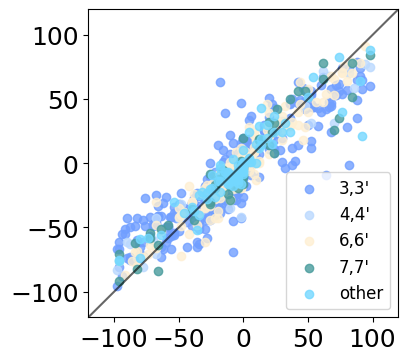

In [35]:
plt.figure(figsize=(4,4))
colors = ['#719fff', '#bbd9fe', '#feefd2', '#489b9c', '#74d8ff', '#e6e6e6']
names = ["3,3\'", '4,4\'', '6,6\'', '7,7\'', 'other']
for binol_split_id, binol_split in enumerate(all_binol_split):
    row_in_split = [id_ for id_, each in data_csv.iterrows() if each['Binol'] in binol_split]
    plt.scatter(target[row_in_split], all_pred[row_in_split], c=colors[binol_split_id], alpha=0.8, label=names[binol_split_id])
plt.legend(fontsize=12, loc='lower right')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot([-120, 120], [-120, 120], c='black', alpha=0.6)
plt.xlim(-120, 120)
plt.ylim(-120, 120)
plt.savefig('test.png', dpi=300, bbox_inches='tight')

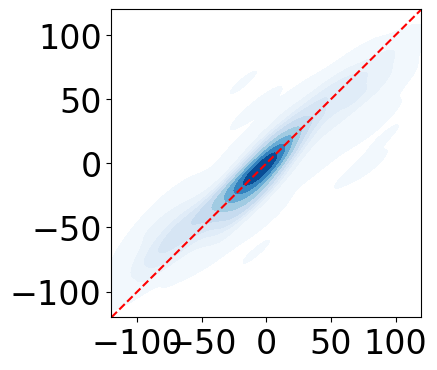

In [17]:
Tool.plot_scatter_with_metrics(y, all_pred, min_=-120, max_=120, figsize=(4,4))


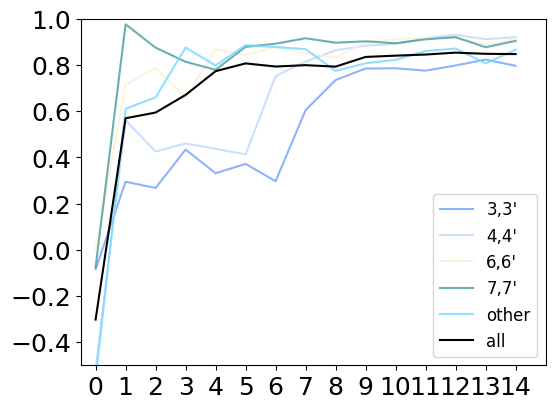

In [25]:
plt.figure(figsize=(6, 4.5))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

for color, r2_split, name in zip(['#719fff', '#bbd9fe', '#feefd2', '#489b9c', '#74d8ff', '#e6e6e6'], all_r2_split, ["3,3\'", '4,4\'', '6,6\'', '7,7\'', 'other']):
    plt.plot(np.arange(len(r2_split)), r2_split, c=color, label=name, alpha=0.8)
plt.plot(np.arange(len(final_all_r2s)), final_all_r2s, c='black', label="all", )
plt.ylim(-0.5,1)
plt.xlim(-0.5,15)
plt.xticks(np.arange(0,15,1))
plt.legend(fontsize=12)
plt.savefig('test.png', dpi=300, bbox_inches='tight')

In [19]:
with open("Data/Modeling_Result.pkl", 'wb') as f:
    pickle.dump([final_all_r2s, final_mae, final_pred, all_r2_split], f)

In [ ]:
with open("Data/Modeling_Result.pkl", 'rb') as f:
    final_all_r2s, final_mae, final_pred, all_r2_split = pickle.load(f)